# ERT inversion - beyond the standard

Here, we exemplify the possibilities of pyGIMLi by treating an ERT timelapse data set. Most of the strategies are independent on the method and can be used for other types of data.

The data set here was published by Hübner et al. (2017) and describes a shallow infiltration experiment using a surface electrode layout.

![Survey layout](survey.png)

In [2]:
# We import some basic libraries like numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Furthermore we import pygimli and two of its modules
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt
from pygimli.viewer import pv

From the whole timelapse set of data files we load a single one, show its properties.

In [4]:
data = pg.getExampleData("ert/Huebner2017/020.dat")
print(data)

18/03/24 - 17:23:26 - pyGIMLi - INFO - Looking for ert/Huebner2017/020.dat in gimli-org/example-data/


Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


The data contains 2849 data using 392 electrodes. In the data container, there are the A-B-M-N numbers of the electrodes and resistances (`'r'`). We first plot the electrode positions (Hübner et al. 2017, Fig. 1).

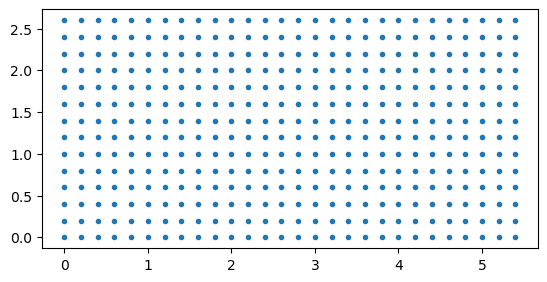

In [5]:
plt.plot(pg.x(data), pg.y(data), ".")
plt.gca().set_aspect(1.0);

We first compute geometric factors and apparent resistivities and store both in the data container.

In [6]:
data["k"] = ert.geometricFactors(data)
data["rhoa"] = data["r"] * data["k"]

The data exhibit mostly dipole-dipole data measured with a 12-channel ABEM Terrameter LS2 instrument. To fill up the channels, some multi-gradient and some square arrays have been added. We can have a look at the data by using `data.show()`. The `style` argument generates a crossplot of the A over the M electrode. See [`ert.showERTData`](https://www.pygimli.org/pygimliapi/_generated/pygimli.physics.ert.html#pygimli.physics.ert.showERTData).

18/03/24 - 17:23:32 - pyGIMLi - INFO - found 245 x values
18/03/24 - 17:23:32 - pyGIMLi - INFO - found 143 y values
18/03/24 - 17:23:32 - pyGIMLi - INFO - x vector length: 2849
18/03/24 - 17:23:32 - pyGIMLi - INFO - y vector length: 2849
18/03/24 - 17:23:32 - pyGIMLi - INFO - v vector length: 2849
18/03/24 - 17:23:32 - pyGIMLi - INFO - 1390 data of 2849 not shown


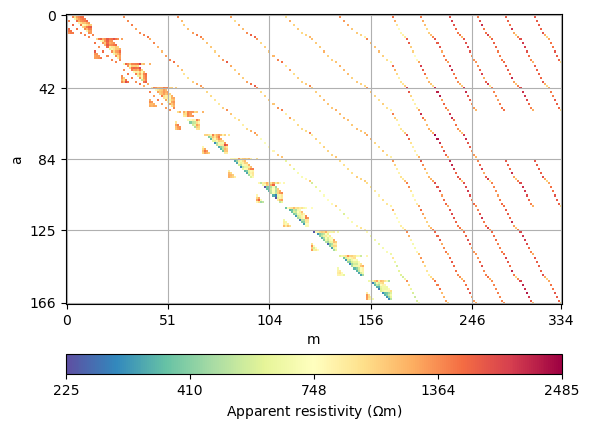

In [7]:
data.show(style="A-M");

We can already see the pseudosections on the main diagonal with some reciprocals mirrored at the diagonal, plus some measurements between the lines (off-diagonals).

## Reciprocal data analysis
For inversion we need an error estimate to weight the individual data. The analysis of normal 
We have a very limited amount of reciprocal data pairs with which we can do a reciprocal analysis, i.e. a statistical analysis of the reciprocity deviations as a function of the measured resistance.
For an example with more rigorous data and background of normal-reciprocal analysis see, based on Udphuay et al. (2011) paper, see
https://dev.pygimli.org/_examples_auto/3_ert/plot_10_reciprocal_analysis.html 
We generate an error model by assuming a relative error of 2%.

In [8]:
data.estimateError(relativeError=0.02)

We extract a single profile from the data.

Data: Sensors: 14 data: 71, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid']


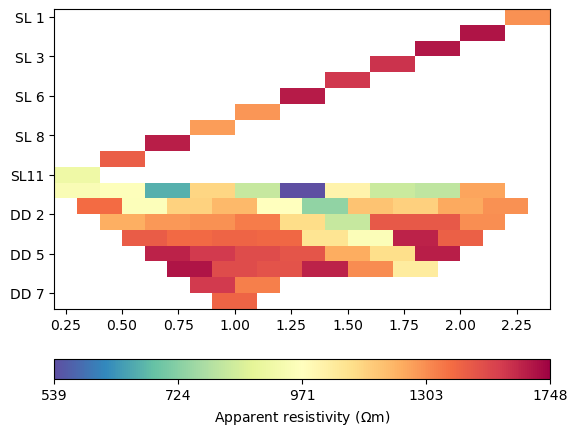

In [9]:
x0 = data.subset(x=0)
print(x0)
x0.setSensors(np.column_stack([pg.y(x0), pg.x(x0)])) # auto for x/y
ax, cb = x0.show()

The upper part is a single multi-gradient using the outermost electrodes, the lower a dipole-dipole section. If we think one of the values is an outlier, we can remove it by logical operations.

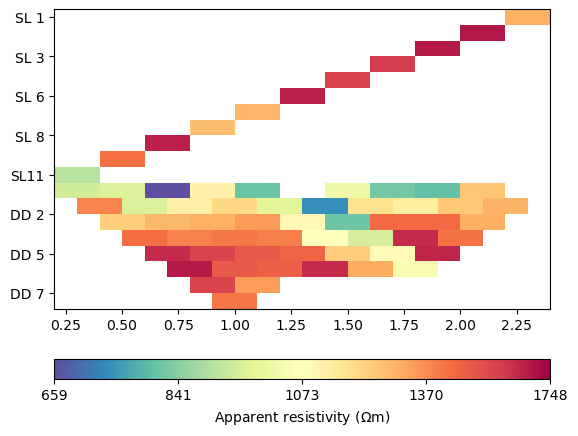

In [10]:
x0.remove(x0["rhoa"] < 600)
ax, cb = x0.show()

In [12]:
mgr = ert.Manager(x0)
mgr.invert(verbose=True)

18/03/24 - 15:26:14 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 15:26:14 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 15:26:14 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 15:26:14 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 15:26:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 15:26:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/03/24 - 15:26:14 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
18/03/24 - 15:26:14 - pyGIMLi - INFO - Use median(data values)=1340.4949999999994
18/03/24 - 15:26:14 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=1340.495000/1340.495000
18/03/24 - 15:26:14 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000254AB699770>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000254AB6999A0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000254AB699950>
min/max (data): 659/1748
min/max (error): 2%/2.01%
min/max (start model): 1340/1340
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  135.70
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   17.22 (dPhi = 85.90%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.71 (dPhi = 74.48%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.65 (dPhi = 1.79%) lam: 20.0
################################################################################
#                Abort criterion reached: dPhi = 1.79 (< 2.0%)         

186 [859.3053482087117,...,1921.7299668901817]

The data seem to be fitted well. First, we want to compare measured and modelled data by `showFit()` and in more detail by `showMisfit()`.

Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy


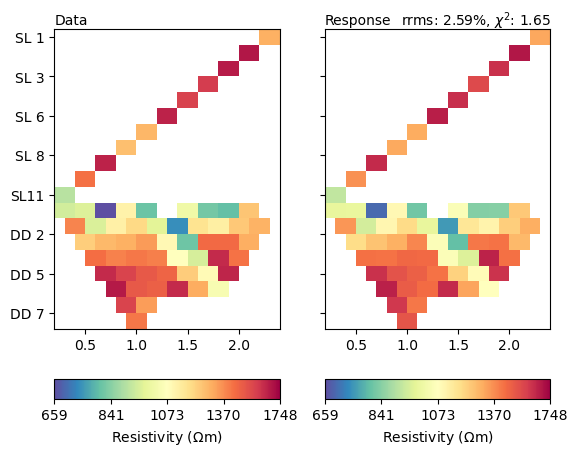

In [13]:
mgr.showFit();

For details on RMS and chi-square values see the tutorial

https://www.pygimli.org/_tutorials_auto/3_inversion/plot_1-polyfit.html

Detecting small distances, using mm accuracy


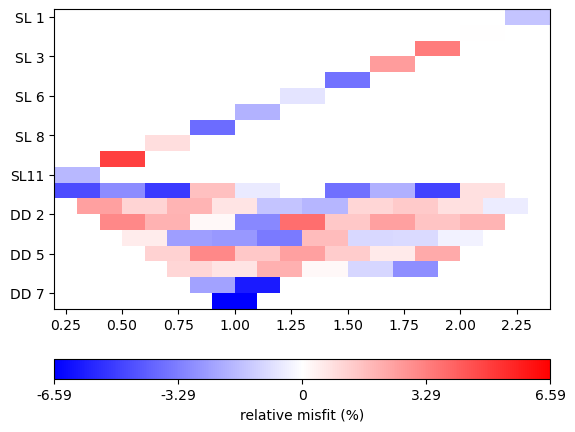

In [14]:
mgr.showMisfit()

There is some limited systematics in the misfit distribution.
Nevertheless, we feel qualified to have a look at the inversion result.

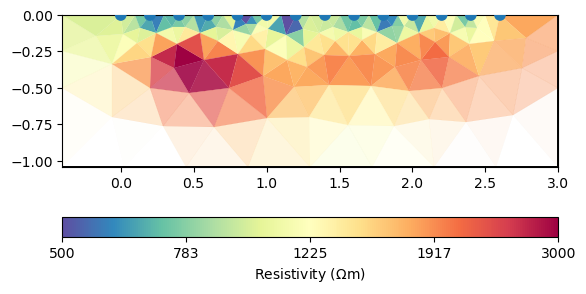

In [15]:
# We show the result using a predefined color-scale
kw = dict(cMin=500, cMax=3000, cMap="Spectral_r", logScale=True)#,
        #   xlabel="x (m)", ylabel="z (m)")
ax, cb = mgr.showResult(**kw)
# we can further modify the figure using the axis and colorbar handles

In [16]:
if 0:
    mesh = mt.createParaMesh2DGrid(  # crashes!!
        x0, paraDX=0.1, paraDZ=0.1, paraDepth=1.2, boundary=1)
    mgr = ert.Manager(x0)
    mgr.setMesh(mesh)
    mgr.invert()
    mgr.showResult(**kw)

We save the result for later visualization. The inversion mesh can be populated with arbitrary keywords by arrays.

In [17]:
x0result = mgr.paraDomain
x0result["res"] = mgr.model

We now choose another profile along the y axis.

Data: Sensors: 14 data: 139, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'ya', 'yb', 'ym', 'yn']
Detecting small distances, using mm accuracy


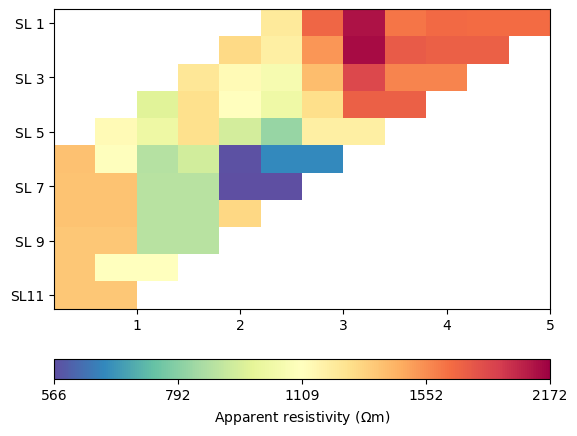

In [ ]:
y1 = data.subset(y=0.6)
y1.setSensors(y1.sensors() * np.array([1, 0, 0]))
print(y1)
y1.show();

18/03/24 - 15:27:13 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 15:27:13 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 15:27:13 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 15:27:13 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 15:27:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 15:27:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/03/24 - 15:27:13 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
18/03/24 - 15:27:13 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
18/03/24 - 15:27:13 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=1227.930000/1227.930000
18/03/24 - 15:27:13 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000254AE2581D0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000254AE258860>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000254AE2528E0>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.10
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   10.23 (dPhi = 94.59%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.69 (dPhi = 89.26%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.69)                   #
################################################################################


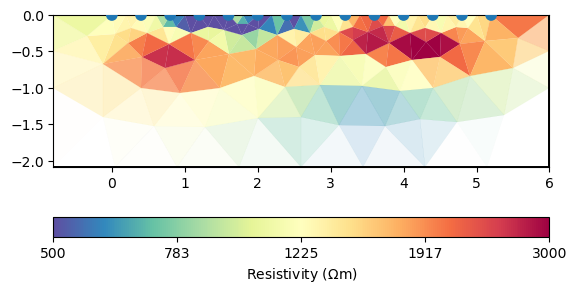

In [19]:
mgr = ert.Manager(y1)
mgr.invert(zWeight=0.3, verbose=True)
ax, cb = mgr.showResult(**kw)

## Mesh generation and regularization
We now want to improve the mesh a bit, step by step, introducing
a smaller boundary, a smaller surface discretization `paraDX`, a
smaller depth, an improved quality and a maximum cell size.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x254ae4f7e50>)

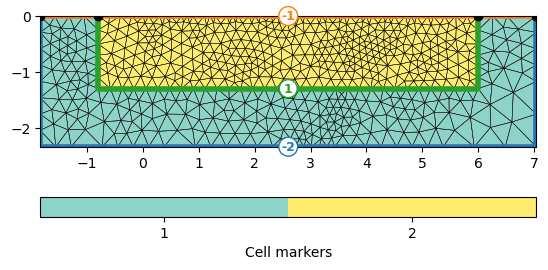

In [21]:
plc = mt.createParaMeshPLC(y1, paraDX=0.25, paraDepth=1.3, 
                           boundary=0.2, paraMaxCellSize=0.03)
mesh = mt.createMesh(plc, quality=34.4, smooth=True)
pg.show(mesh, markers=True, showMesh=True)

18/03/24 - 15:28:55 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 15:28:55 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 15:28:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 15:28:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/03/24 - 15:28:55 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2367 Cells: 4536 Boundaries: 3500
18/03/24 - 15:28:55 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
18/03/24 - 15:28:55 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000
18/03/24 - 15:28:55 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000254AE2581D0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000254AE258860>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000254AB3E79A0>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.10
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   11.87 (dPhi = 93.39%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.29 (dPhi = 80.98%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.93 (dPhi = 9.42%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x254ab3cd850>)

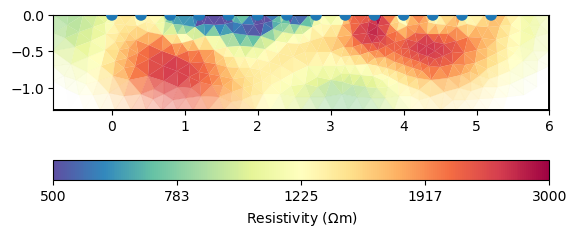

In [22]:
mgr.setMesh(mesh)
mgr.invert(verbose=True)
mgr.showResult(**kw)

The default regularization scheme are smoothness constraints of first-order, i.e. a derivative across the model cells. We can also apply second order constraints by setting this inversion property.

18/03/24 - 15:32:23 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
18/03/24 - 15:32:23 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000




0.7352461936115534


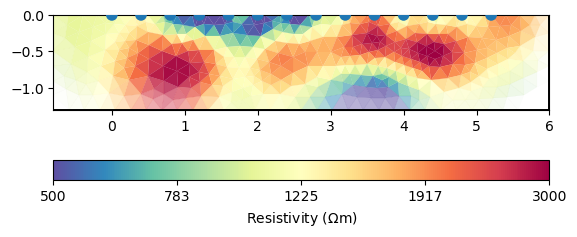

In [28]:
mgr.inv.setRegularization(cType=2)
mgr.invert(verbose=False)
print(mgr.inv.chi2())
ax, cb = mgr.showResult(**kw)

Alternative to classical smoothness constraints, geostatistic operators can be used for regularization. For details on the method see the tutorial
https://www.pygimli.org/_tutorials_auto/3_inversion/plot_6-geostatConstraints.html

18/03/24 - 15:34:39 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
18/03/24 - 15:34:39 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000
18/03/24 - 15:34:39 - pyGIMLi - INFO - Starting inversion.
18/03/24 - 15:34:39 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 2 with: I=[1, 0.1], dip=0, strike=0


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000254AE2581D0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000254AE258860>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000254B655BC40>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------


18/03/24 - 15:34:40 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.2s
18/03/24 - 15:34:40 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\8288165599932659160


inv.iter 0 ... chi² =  194.10
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   42.84 (dPhi = 77.69%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.63 (dPhi = 85.52%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.74 (dPhi = 43.87%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    0.95 (dPhi = 46.68%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.95)                   #
################################################################################


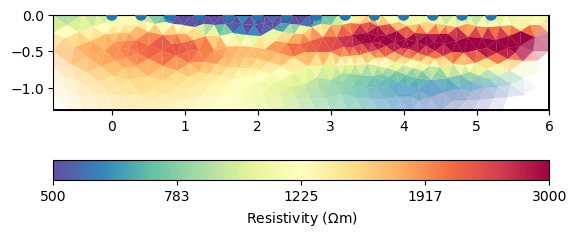

In [30]:
mgr.inv.setRegularization(correlationLengths=[1, 0.1])
mgr.invert(verbose=True)
ax, cb = mgr.showResult(**kw)

For a more extensive comparison of regularization methods, see the tutorial https://www.pygimli.org/_tutorials_auto/3_inversion/plot_5_Regularization.html

Other options to discuss or link
* lam
* limits
* 

## Additional information
### Structural constraints
Imagine we have knowledge on a geological interface, e.g. from seismic or GPR reflections. To include this structural information into the inversion, we create a line with a marker>0 and re-create the mesh. 

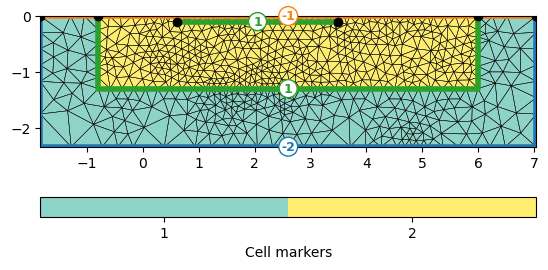

In [31]:
line = mt.createLine(start=[0.6, -0.1], end=[3.5, -0.1], marker=1)
# pg.show(plc+line)
mesh = mt.createMesh(plc+line, quality=34.4)
ax, cb = pg.show(mesh, markers=True, showMesh=True)

The interface is built into the mesh and deactivates smoothness constraints across it in inversion. For a more rigorous example see
https://www.pygimli.org/_examples_auto/6_inversion/plot_4_structural_constraints.html

We create a new manager, set the created mesh and run inversion.

18/03/24 - 15:37:04 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 15:37:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 15:37:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 15:37:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/03/24 - 15:37:04 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2668 Cells: 5140 Boundaries: 3952
18/03/24 - 15:37:04 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
18/03/24 - 15:37:04 - pyGIMLi - INFO - Created startmodel from forward operator: 827, min/max=1227.930000/1227.930000


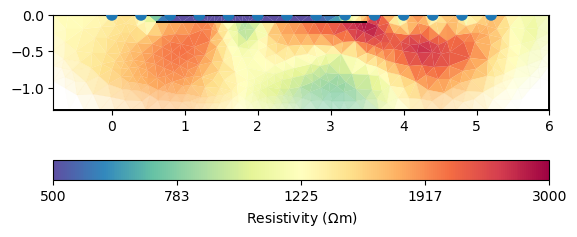

In [32]:
mgr = ert.Manager(y1)  # only setMesh fails!!
mgr.setMesh(mesh)
mgr.invert()
ax, cb = mgr.showResult(**kw)

As a result, there is a sharp contrast in the area of the infiltration, whereas outside the effect of the constraint is lower. 

### Region-specific inversion
The regularization does not have to be the same for the whole modelling domain. We create a cube under the infiltration area for which we use different settings.

In [33]:
print("TODO")

TODO


For a more thorough overview on the region options see the tutorial
https://www.pygimli.org/_tutorials_auto/3_inversion/plot_8-regionWise.html

### Parameter constraints
Besides from structural information, one may have parameter information, e.g. from a borehole or direct-push sounding. For an example, see
https://www.pygimli.org/_examples_auto/6_inversion/plot_5_ert_with_priors.html

### Bringing petrophysics into inversion


## 3D visualization
Now we bring the 2D result of the y-directed profile  into 3D by changing the dimension, switching y (in 2D depth axis) and z coordinates and shifting the mesh into the correct y position.

In [34]:
y1result = mgr.paraDomain
y1result["res"] = mgr.model
y1result.setDimension(3)
y1result.swapCoordinates(1, 2) # make 2D depth to 3D depth
y1result.translate([0, 0.6, 0])

Mesh: Nodes: 466 Cells: 827 Boundaries: 122
Mesh contains data: res

Similarly, we do so for the y-directed profile x0, for which we additionally have to exchange the x with the y coordinate

In [35]:
x0result.setDimension(3)
x0result.swapCoordinates(1, 2) # make 2D depth to 3D depth
x0result.swapCoordinates(0, 1) # make 2D x to 3D y

In [37]:
pl, _ = pg.show(x0result, "res", **kw, hold=True)
pv.drawMesh(pl, y1result, label="res", **kw)
pl.show()

Widget(value='<iframe src="http://localhost:54030/index.html?ui=P_0x254c40c6850_1&reconnect=auto" class="pyvis…

## 3D inversion
For a 3D inversion of all data, one needs to create a 3D mesh. To do so, first the geometry is created and then meshes (just like in 2D).

In [38]:
plc = mt.createParaMeshPLC3D(data)
mesh = mt.createMesh(plc, quality=1.3)
print(mesh)
pg.show(mesh, style="wireframe")

Mesh: Nodes: 1762 Cells: 7984 Boundaries: 16854


Widget(value='<iframe src="http://localhost:54030/index.html?ui=P_0x254c3c38f70_2&reconnect=auto" class="pyvis…

(<pyvista.plotting.plotter.Plotter at 0x254c3c38f70>, None)

In [39]:
mgr3d = ert.Manager(data)
mgr3d.setMesh(mesh)
mgr3d.invert(verbose=True)

18/03/24 - 16:04:19 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 16:04:19 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 16:04:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 16:04:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/03/24 - 16:04:21 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 12393 Cells: 63872 Boundaries: 67416
18/03/24 - 16:04:21 - pyGIMLi - INFO - Use median(data values)=1126.759999999999
18/03/24 - 16:04:21 - pyGIMLi - INFO - Created startmodel from forward operator: 4018, min/max=1126.760000/1126.760000
18/03/24 - 16:04:21 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000254C51AE130>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000254C51AE450>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000254C51AE0E0>
min/max (data): 151/2542
min/max (error): 2%/2.05%
min/max (start model): 1127/1127
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  336.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   24.08 (dPhi = 92.08%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   11.37 (dPhi = 46.08%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.84 (dPhi = 35.73%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    4.36 (dPhi = 14.36%) lam: 20.0
--------------

4018 [1144.6201143788828,...,551.5735595297559]

In [41]:
result3d = mgr3d.paraDomain
result3d["res"] = mgr3d.paraModel()
# pg.show(result3d, "res", **kw);
pl, _ = pg.show(result3d, label="res", style="surface", hold=True, **kw,
                filter={"threshold": dict(value=400, scalars="res", method="lower")})
pv.drawMesh(pl, result3d, label="res", style="surface", **kw,
            filter={"slice": dict(normal="y", origin=[0, 1, 0])})
pl.show()

Widget(value='<iframe src="http://localhost:54030/index.html?ui=P_0x254c6299070_4&reconnect=auto" class="pyvis…

## Timelapse inversion

For this data set, we have a lot of data over a couple of days.
Of course, we could invert these step by step and compare the
individual models (SHOULD WE DO THAT HERE?).
For timelapse ERT, there is a specialized class `TimelapseERT`.
It handles the data, e.g. filtering and masking, but also 
exhibits several timelapse strategies, such as 4D inversion.

For more details, see the example on
https://www.pygimli.org/_examples_auto/3_ert/plot_09_ert_timelapse.html

In [42]:
tl = ert.TimelapseERT("*.dat")
print(tl)

18/03/24 - 16:06:44 - pyGIMLi - INFO - Cache c:\Guenther.T\src\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 3): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\15129487419898899544


Timelapse ERT data:
Data: Sensors: 392 data: 972, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']
7 time steps from 2024-03-18 16:06 to 2024-03-24 16:06


(array([0.00978302, 0.00442956, 0.00533587, 0.00510618, 0.00547779,
        0.00511538, 0.00545342]),
 array([0.68752327, 0.20776151, 0.18058016, 0.31989094, 0.23673541,
        0.28763426, 0.23571159]))

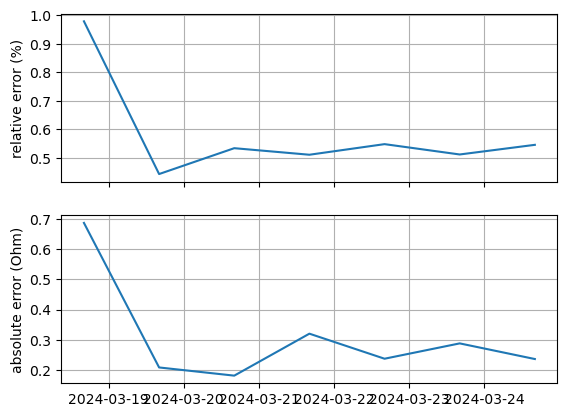

In [43]:
tl.fitReciprocalErrorModel(rel=False, show=True)

For a more rigorous explanation of timelapse strategies see

https://www.pygimli.org/_examples_auto/3_ert/plot_09_ert_timelapse.html

In [44]:
tl.fullInversion()

18/03/24 - 16:07:49 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 16:07:49 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 16:07:50 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 16:07:50 - pyGIMLi - INFO - Region with smallest marker (1) set to background
18/03/24 - 16:07:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 16:07:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/03/24 - 16:07:50 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 9117 Cells: 13648 Boundaries: 12528
18/03/24 - 16:07:50 - pyGIMLi - INFO - Starting inversion.


3087 model cells
Mesh: Nodes: 9117 Cells: 13648 Boundaries: 12528
fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x000002552E25F040>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002552E2494C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002552E25F680>
min/max (data): 528/2682
min/max (error): 3%/1.0e+10%
min/max (start model): 1251/1251
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 26475.98
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 2953.62 (dPhi = 88.79%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  538.47 (dPhi = 81.58%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  310.96 (dPhi = 42.15%) lam: 20.0
--------------------------------------------------------------------------------
in

## References
* Hübner, R., Günther, T., Heller, K., Noell, U. & Kleber, A. (2017): Impacts of a capillary barrier on infiltration and subsurface stormflow in layered slope deposits monitored with 3-D ERT and hydrometric measurements. Hydrol. Earth Syst. Sci. 21, 5181-5199, [doi:10.5194/hess-21-5181-2017](https://doi.org/10.5194/hess-21-5181-2017).
* Jordi, C., Doetsch, J., Günther, T., Schmelzbach, C. & Robertsson, J.O.A. (2018): Geostatistical regularisation operators for geophysical inverse problems on irregular meshes. Geophys. J. Int. 213, 1374-1386, [doi:10.1093/gji/ggy055](https://doi.org/10.1093/gji/ggy055).
* Grünenbaum, N., Günther, T., Greskowiak, J., Vienken, T., Müller-Petke, M. & Massmann, G. (2023): Salinity distribution in the subterranean estuary of a meso-tidal high-energy beach characterized by Electrical Resistivity Tomography and Direct Push technology. J. of Hydrol. 617, 129074, [doi:10.1016/j.jhydrol.2023.129074](https://doi.org/10.1016/j.jhydrol.2023.129074).
* Rücker, C., Günther, T., Wagner, F.M. (2017): pyGIMLi: An open-source library for modelling and inversion in geophysics, Computers & Geosciences 109, 106-123, [doi:10.1016/j.cageo.2017.07.011](https://doi.org/10.1016/j.cageo.2017.07.011).
* Hübner, R., Heller, K., Günther, T. & Kleber, A. (2015): Monitoring hillslope moisture dynamics with sur- face ERT for enhancing spatial significance of hydrometric point measurements. Hydrology and Earth System Sciences 19(1), 225-240, [doi:10.5194/hess-19-225-2015](https://doi.org/10.5194/hess-19-225-2015).
* Udphuay, S., Günther, T., Everett, M.E., Warden, R.R. & Briaud, J.-L. (2011): Three-dimensional resistivity tomography in extreme coastal terrain amidst dense cultural signals: application to cliff stability assessment at the historic D-Day site. Geophys. J. Int. 185(1), 201-220, [doi:10.1111/j.1365-246X.2010.04915.x](https://doi.org/10.1111/j.1365-246X.2010.04915.x).


